In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rebound
import emcee
import corner
import astropy.units as u
from astropy.constants import M_sun, M_earth, M_jup, au, R_sun, R_jup, R_earth
from astropy.timeseries import LombScargle


# Q1
[completed]

# Q2

### Set up planetary system parameters 
[data](http://www.openexoplanetcatalogue.com/planet/Kepler-289%20c/) from the open exoplanet catalog

In [2]:
mass_star = (1.08 * M_sun).cgs.value
mass_289c = (.41 * M_jup).cgs.value
mass_289d = (4.1 * M_earth).cgs.value

r_star = (1. * R_sun).cgs.value
r_289c = (1.034 * R_jup).cgs.value
r_289d = (.239 * R_jup).cgs.value

P_289c = (125.852 * u.day).cgs.value
P_289d = (66.063 * u.day).cgs.value

a_P289c = (.51 * u.au).cgs.value
a_P289d = (.33 * u.au).cgs.value



### Set up system in rebound

In [3]:
sim = rebound.Simulation()
sim.units = ["g", "cm", "s"]

sim.add(m=mass_star, r = r_star) #star
sim.add(m=mass_289d, r = r_289d, a = a_P289d) 
sim.add(m=mass_289c, r = r_289c, a = a_P289c) 
sim.move_to_com()

##### check that the orbital periods about expected

In [4]:
(sim.particles[1].P * u.s).to(u.day)

<Quantity 66.6288229 d>

In [5]:
(sim.particles[2].P * u.s).to(u.day)

<Quantity 127.98757717 d>

#### Display orbits

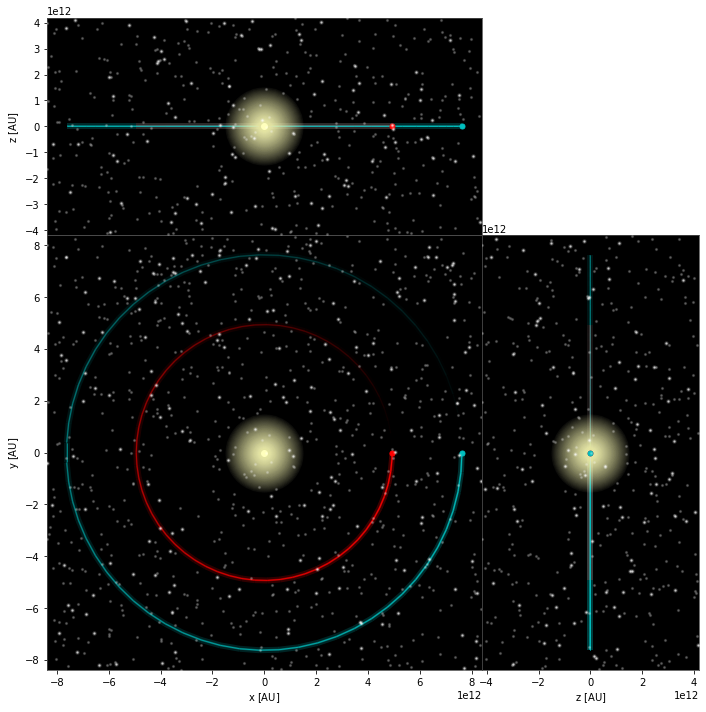

In [6]:
fig, ax, _, _ = rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=True, fancy=True, slices=0.5, figsize=(12, 12))
# thanks Tom for pointing out the fancy=True param

#### Define some functions for the problem

In [7]:
def create_kepler289_sim(inv_sini=1):
    # start simulation, adjust units
    sim = rebound.Simulation()
    sim.units = ("yr", "AU", "Msun")

    sim.add(m=kepler289star["mass"].to(u.Msun).value, r=kepler289star["radius"].to(u.AU).value)
    sim.add(m=kepler289d["mass"].to(u.Msun).value * inv_sini, r=kepler289d["radius"].to(u.AU).value, a=kepler289d["a"].to(u.AU).value)
    sim.add(m=kepler289c["mass"].to(u.Msun).value * inv_sini, r=kepler289c["radius"].to(u.AU).value, a=kepler289c["a"].to(u.AU).value)
    sim.move_to_com()
    
    return sim

In [8]:

def integrate_kepler289(inv_sini=1, plot=False):
    sim = rebound.Simulation()
    sim.units = ["g", "cm", "s"] # use cgs units

    # init sim
    sim.add(m=mass_star, r = r_star) #star
    sim.add(m=mass_289d * inv_sini, r = r_289d, a = a_P289d) 
    sim.add(m=mass_289c * inv_sini, r = r_289c, a = a_P289c) 
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = 2e-4 * sim.particles[1].P
    
    # record a, e if plot == True
    if plot == True:
        Noutputs = 1000
        times = np.linspace(0, 1000 * sim.particles[1].P, Noutputs)
        a1 = np.zeros(Noutputs)
        e1 = np.zeros(Noutputs)    
        a2 = np.zeros(Noutputs)
        e2 = np.zeros(Noutputs)
        for i,time in enumerate(times):
            sim.integrate(time, exact_finish_time=0)
            a1[i] = sim.particles[1].a
            e1[i] = sim.particles[1].e
            a2[i] = sim.particles[2].a
            e2[i] = sim.particles[2].e

        fig = plt.figure(figsize=(15,5))

        ax = plt.subplot(121)
        ax.set_xlabel("time")
        ax.set_ylabel("semi-major axis")
        plt.plot(times, a1);
        plt.plot(times, a2);

        ax = plt.subplot(122)
        ax.set_xlabel("time")
        ax.set_ylabel("eccentricity")
        plt.plot(times, e1);
        plt.plot(times, e2);

        plt.show()
    
    else: 
        sim.integrate(1000 * sim.particles[1].P, exact_finish_time=0)

    # define stability as whether the planet remains in the system
    stable = False if (sum(e1>= 1) + sum(e2 >= 1)) > 0 else True
    return stable

### Find masses at which the orbits become unstable
Orbits that remain bound over 1000 orbits are "stable". The plots show the evolution of semimajor axis (a) and eccentricity (e) over time

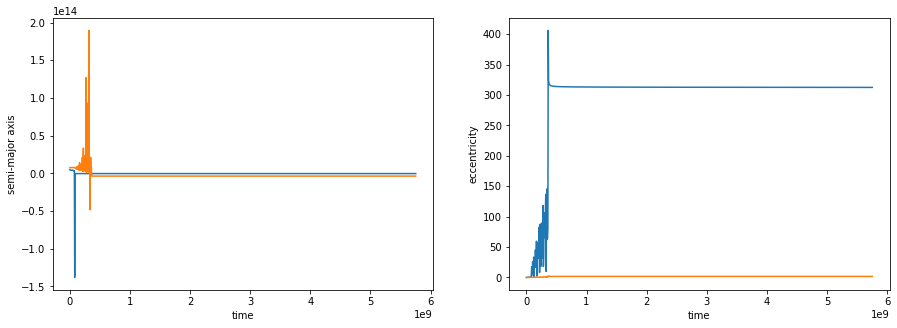

False

In [9]:
# establish an upper bound at  arcsin(i) == 100
integrate_kepler289(inv_sini=100, plot=True)

#### binary search until we find the greatest mass at which the system is stable over 1000 orbits

TRIAL 1


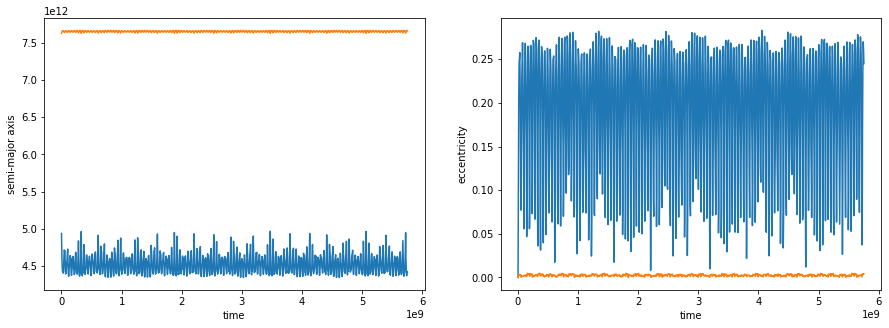

Test: inv_sini = 50.5, stability = True
Remaining range [50.500, 100.000]
----------------------------------------------------------------------------------------------------
TRIAL 2


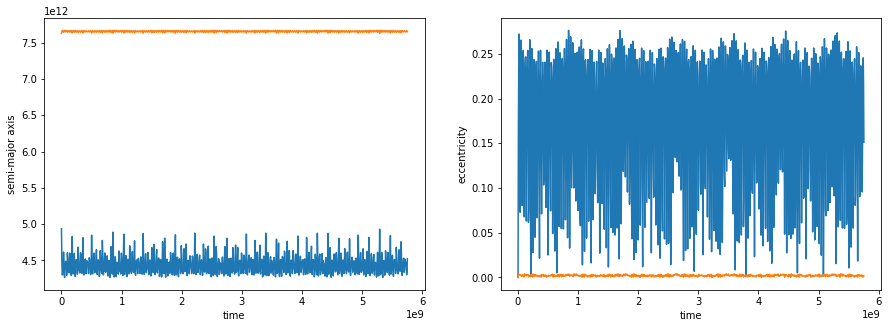

Test: inv_sini = 75.25, stability = True
Remaining range [75.250, 100.000]
----------------------------------------------------------------------------------------------------
TRIAL 3


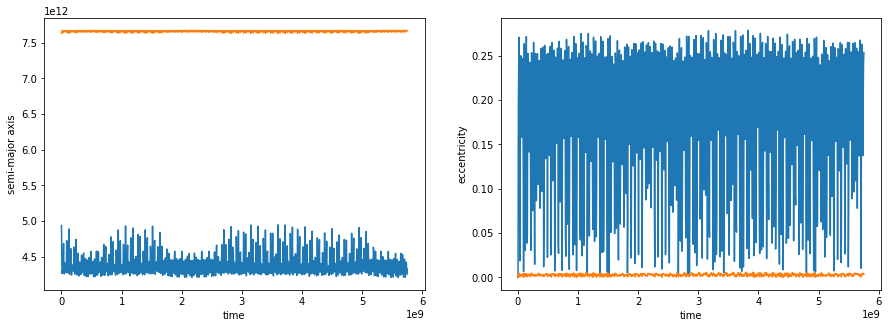

Test: inv_sini = 87.625, stability = True
Remaining range [87.625, 100.000]
----------------------------------------------------------------------------------------------------
TRIAL 4


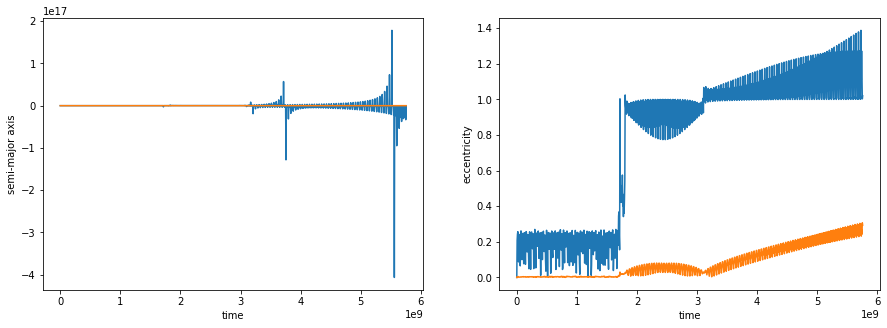

Test: inv_sini = 93.8125, stability = False
Remaining range [87.625, 93.812]
----------------------------------------------------------------------------------------------------
TRIAL 5


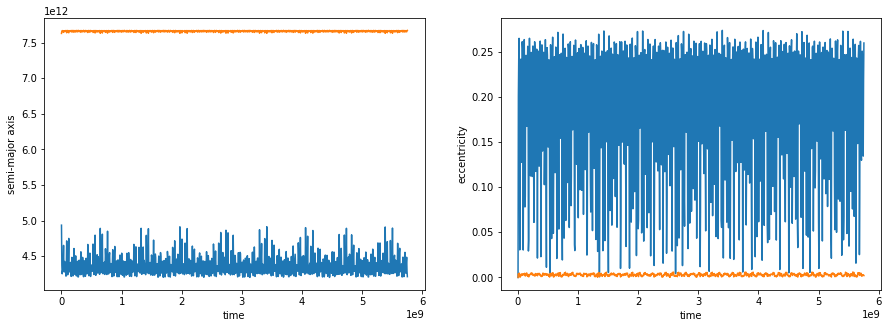

Test: inv_sini = 90.71875, stability = True
Remaining range [90.719, 93.812]
----------------------------------------------------------------------------------------------------
TRIAL 6


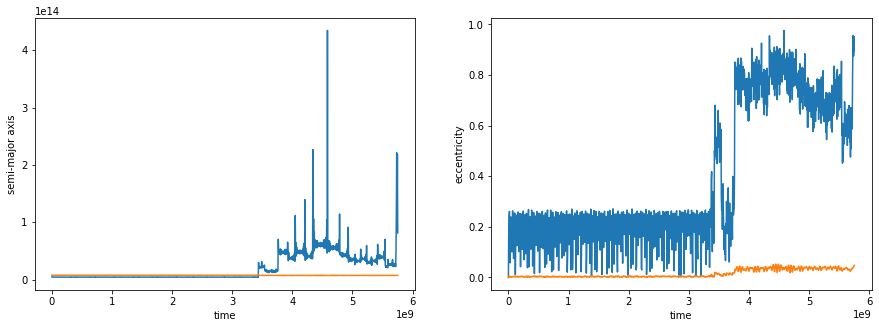

Test: inv_sini = 92.265625, stability = True
Remaining range [92.266, 93.812]
----------------------------------------------------------------------------------------------------
TRIAL 7


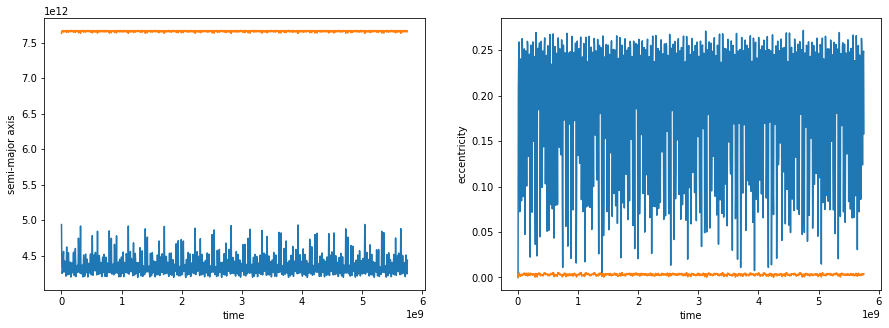

Test: inv_sini = 93.0390625, stability = True
Remaining range [93.039, 93.812]
----------------------------------------------------------------------------------------------------
TRIAL 8


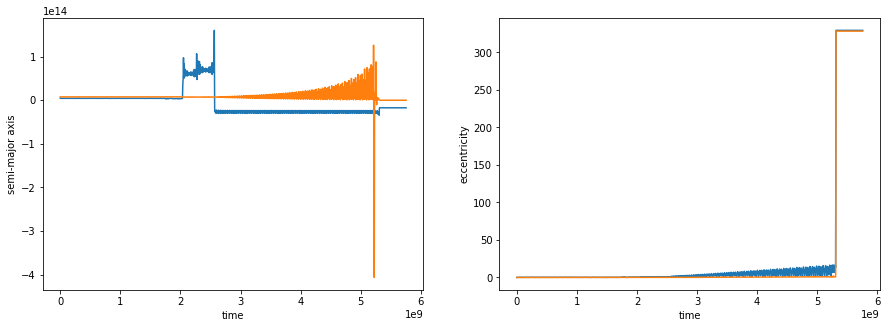

Test: inv_sini = 93.42578125, stability = False
Remaining range [93.039, 93.426]
----------------------------------------------------------------------------------------------------
TRIAL 9


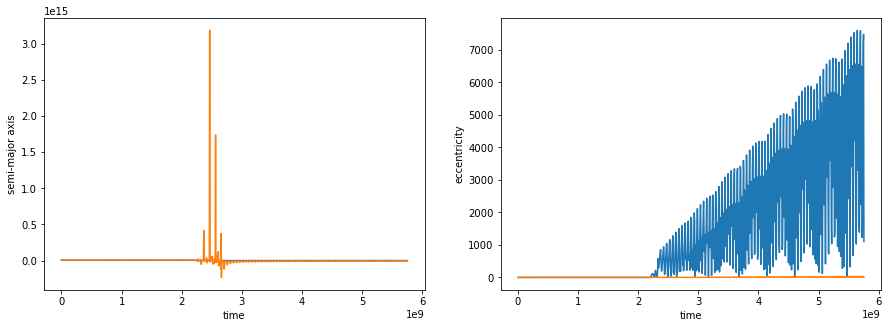

Test: inv_sini = 93.232421875, stability = False
Remaining range [93.039, 93.232]
----------------------------------------------------------------------------------------------------
TRIAL 10


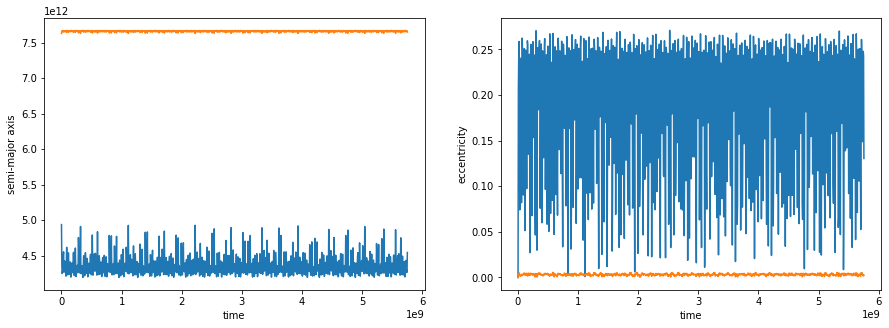

Test: inv_sini = 93.1357421875, stability = True
Remaining range [93.136, 93.232]
----------------------------------------------------------------------------------------------------
TRIAL 11


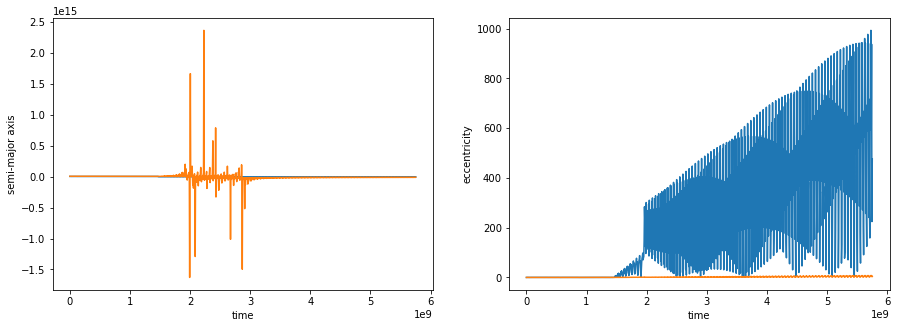

Test: inv_sini = 93.18408203125, stability = False
Remaining range [93.136, 93.184]
----------------------------------------------------------------------------------------------------
TRIAL 12


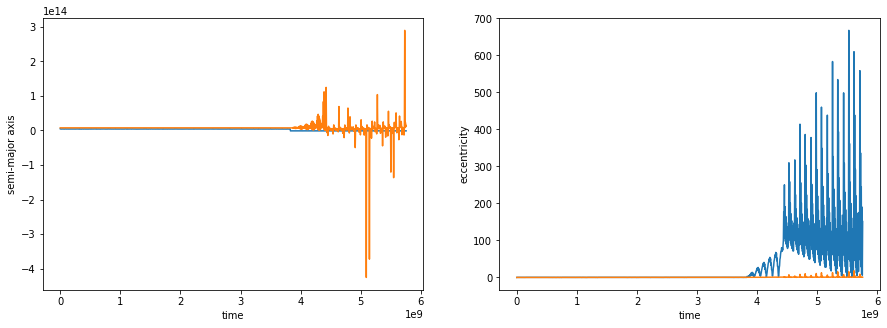

Test: inv_sini = 93.159912109375, stability = False
Remaining range [93.136, 93.160]
----------------------------------------------------------------------------------------------------
TRIAL 13


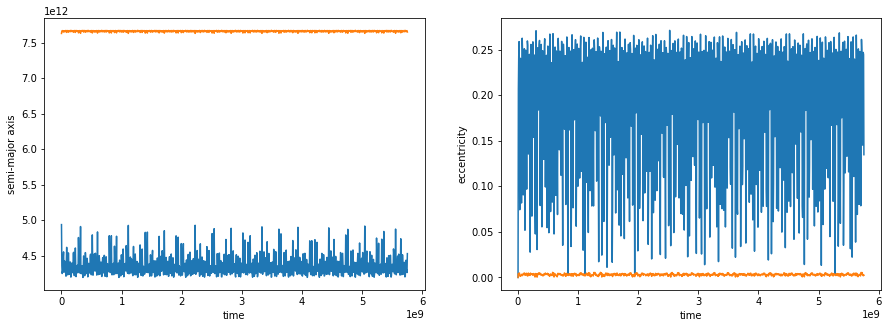

Test: inv_sini = 93.1478271484375, stability = True
Remaining range [93.148, 93.160]
----------------------------------------------------------------------------------------------------
TRIAL 14


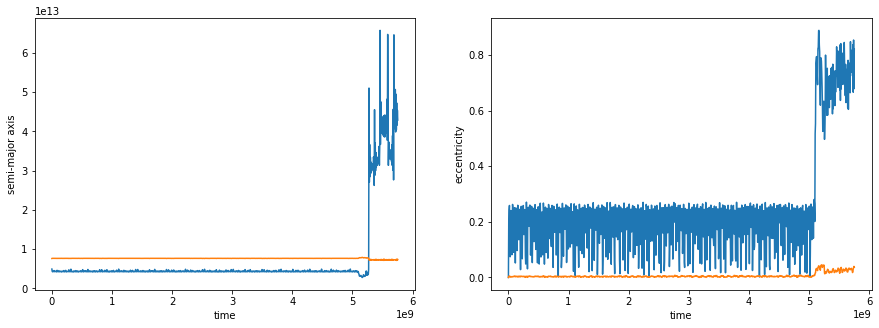

Test: inv_sini = 93.15386962890625, stability = True
Remaining range [93.154, 93.160]
----------------------------------------------------------------------------------------------------


In [10]:
inv_sini_bounds = [1, 100]
i = 0
while inv_sini_bounds[1] - inv_sini_bounds[0] > 1e-2:
    i += 1
    print(f'TRIAL {i}')
    
    inv_sini = np.mean(inv_sini_bounds)
    stable = integrate_kepler289(inv_sini, plot=True)

    if stable:
        inv_sini_bounds[0] = inv_sini
    else:
        inv_sini_bounds[1] = inv_sini

    print(f"Test: inv_sini = {inv_sini}, stability = {stable}")
    print(f"Remaining range [{inv_sini_bounds[0]:1.3f}, {inv_sini_bounds[1]:1.3f}]")
    print('-' * 100)

So the minimum inclination is:

In [11]:
min_i = np.arcsin(1 / 93.15)

In [12]:
min_i

0.010735579270373935

Since RV measures $M \sin{i}$, we can find the maximum masses by dividing by $\sin{i}$

In [13]:
print(f'Maximum mass of Kepler 289c: {((mass_289c / np.sin(min_i)) * u.g).si / M_jup:.2f} M_jup')
print(f'Maximum mass of Kepler 289d: {((mass_289d / np.sin(min_i)) * u.g).si / M_jup:.2f} M_jup')

Maximum mass of Kepler 289c: 38.19 M_jup
Maximum mass of Kepler 289d: 1.20 M_jup


Note that our stability criteria is pretty weak, and that even around an arcsin(i) of ~92deg (Trial 6) there were some massive instabilities in the orbit of planet d, which became highly eccentric. However, we can also see that the transition into instability is not sharp, as the orbits in Trial 10, with arcsin(i) > 93 appear to be fairly stable. Thus the values above are pretty good upper bounds as inclinations below 0.01 seem to produce masses that are consistently unstable.

# Q3
https://rebound.readthedocs.io/en/latest/ipython_examples/RadialVelocity/

*Simulate the edge-on radial velocity of the star, and then fit this RV with two Keplerian orbits. How big are the residuals? How does this compare to typical RV errors?*

#### set up system

In [14]:
sim = rebound.Simulation()
sim.units = ["g", "cm", "s"]

sim.add(m=mass_star, r = r_star) #star
sim.add(m=mass_289d, r = r_289d, a = a_P289d) 
sim.add(m=mass_289c, r = r_289c, a = a_P289c) 
sim.move_to_com()

#### Use rebound to get 1000 RV measurements over 1 orbit of 289c (125 days)

In [15]:

N=1000
times = np.sort(125*60*60*24*np.linspace(0, 1, N)) # 1000 evenly spaced observations over 125 days
RVs = np.zeros(N)
for i, t in enumerate(times):
    sim.integrate(times[i])
    RVs[i] = sim.particles[0].vx # radial velocity of the host star
# RVs += np.random.normal(size=N, ) # add 20m/s Gaussian noise

##### Plot RVs 
RV is domiated by Kepler 289c, so this shape looks about right

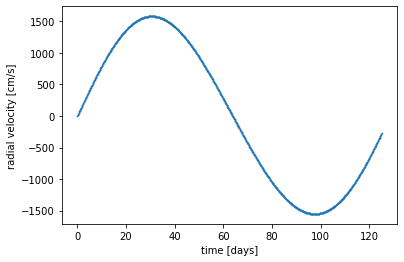

In [16]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [cm/s]")
ax.scatter(times/(24*60*60), RVs, s=.5);

#### Use code from rebound to fit the two keplerian orbits by MCMC

The parameterization is Period (P), l, h, k, and mass

In [17]:
def setup_sim(params):
    P1, P2, l1, l2, h1, h2, k1, k2, m1, m2 = params # unpack
    sim = rebound.Simulation()
    sim.units = ["g", "cm", "s"]
    sim.add(m=mass_star)
    sim.add(m=m1, P=P1, h=h1, k=k1, l=l1)
    sim.add(m=m2, P=P2, h=h2, k=k2, l=l2)
    sim.move_to_com()
    return sim

def log_likelihood(params, times, RVs):
    ll = 0. # We use the log likelihood to avoid numerical issues with very small/large numbers
    sim = setup_sim(params)
    for i, t in enumerate(times):
        sim.integrate(times[i])
        deltaRV = sim.particles[0].vx - RVs[i]
        ll += -(deltaRV)**2
    return ll

#### Set up and run MCMC

In [18]:
ndim, nwalkers = 5*2, 20

# P1, P2, l1, l2, h1, h2, k1, k2, m1, m2
ic = [P_289d, P_289c, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, mass_289d, mass_289c] 
ic = np.tile(ic,(20,1)) # copy initial conditions for each walker
ic += 0.05*np.random.random((20,10))*ic # slightly perturb initial conditions

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[times, RVs])
state = sampler.run_mcmc(ic, 500, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:57<00:00,  2.82it/s]


#### Check log probabilities to make sure MCMC converged

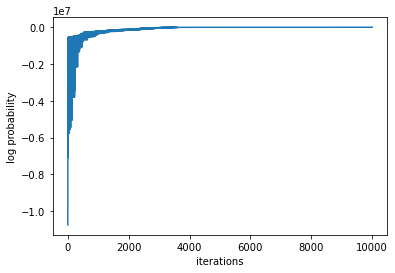

In [20]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("log probability")
ax.plot(sampler.flatlnprobability);

#### Plot corner plot of fitted params with a burnin of 5000

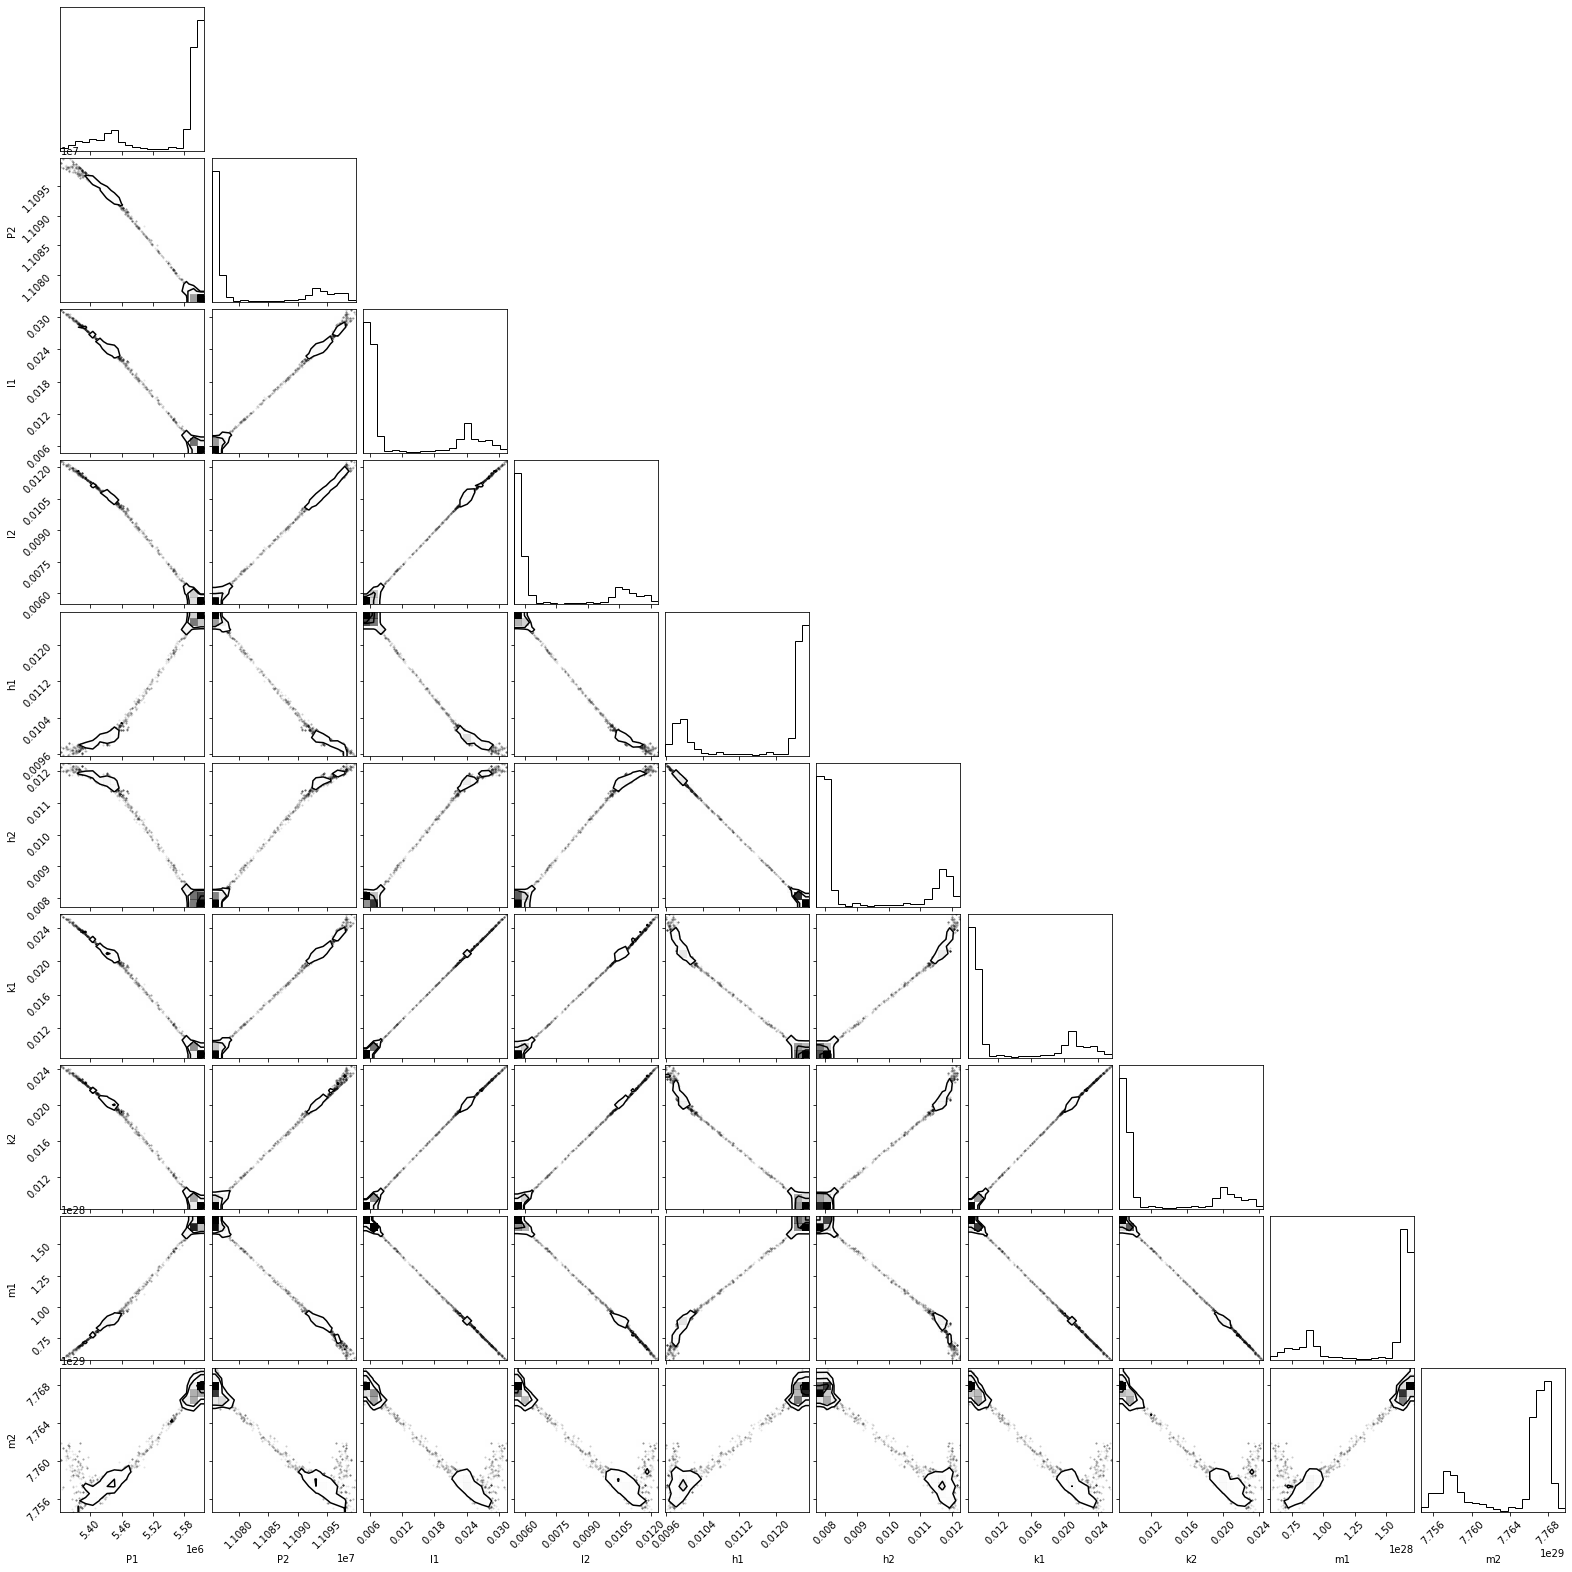

In [21]:
corner.corner(sampler.flatchain[5000:], 
              labels = ["P1","P2","l1","l2","h1","h2","k1","k2","m1","m2"]);

#### Get distribution of residuals

Sample 100 different sets of parameters after burnin, get predicted RV values from integrating those parameters, and find residuals with actual RVs

In [22]:
# fig, ax = plt.subplots(1,1)
# ax.set_xlabel("time [days]")
# ax.set_ylabel("radial velocity [cm/s]")

times_plot = np.linspace(0,times[-1],1000)
RVs_plot = np.zeros(len(times_plot))
Nplot = 100
indx = np.random.choice(5000, Nplot, replace=False)
resids = []
for i in range(Nplot):
    s = setup_sim(sampler.flatchain[5000+indx[i]]) # skipping burn-in
    for j, t in enumerate(times_plot):
        s.integrate(t)
        RVs_plot[j] = s.particles[0].vx
    resids = resids + list((RVs - RVs_plot))
# ax.scatter(times, RVs)
# ax.plot(times_plot, RVs_plot, color="black", alpha=0.13)   

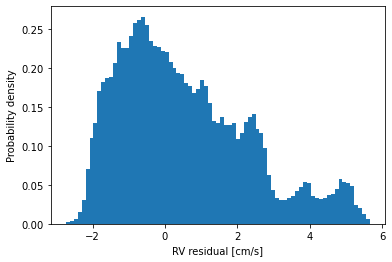

In [23]:
_ = plt.hist(resids, 'fd', density=True)
plt.xlabel('RV residual [cm/s]')
plt.ylabel('Probability density')
plt.show()

#### Plot residuals for one set of parameters

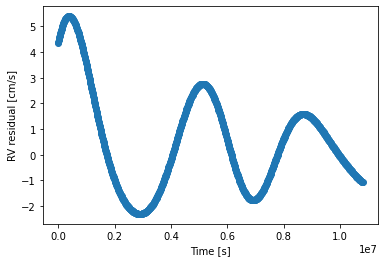

In [24]:
plt.scatter(times, (RVs - RVs_plot))
plt.xlabel('Time [s]')
plt.ylabel('RV residual [cm/s]')
plt.show()

*How big are the residuals? How does this compare to typical RV errors?*

**It looks like most of the residuals are on order cm/s. This is much smaller than typical RV errors (which are around 1m/s) and probably can't be observed.**

# Q4

*Look at the REBOUND TTV example. Make a plot of the TTVs of Kepler-289c/d over 4 years (assuming edge-on, so that planets do in fact transit). Measure amplitude and period of the sinusoidal variation component. How does it change if you vary the mass of Kepler-289c downward and upward by a factor of 2?*

https://rebound.readthedocs.io/en/latest/ipython_examples/TransitTimingVariations/

In [25]:
def get_ampl_per(ts, ttvs, disp=True):  
    # period
    frequency, power = LombScargle(ts, ttvs).autopower()
    argfreq = np.where(power > max(power) * .9)[0][0]
    per =  (1/frequency[argfreq] * u.s).to(u.yr)

    # amplitude
    per_s = per.cgs.value
    ampl = (ttvs[np.where(ts < per_s)[0]].max() - ttvs[np.where(ts < per_s)[0]].min()) / 2
    ampl = (ampl*u.s).to(u.hr)
    if disp:
        print(f'Period of TTV    : {per:.2f}')
        print(f'Amplitude of TTV : {ampl:.2f}')
        return
    return per, ampl

def get_transit_times(planet_ind=1, period=None, years=4, N=None, ttvs=True, mass_factor=1):
    '''If specified, N (number of transits) takes precedence over years'''
    # Set up simulation
    sim = rebound.Simulation()
    sim.units = ["g", "cm", "s"]

    sim.add(m=mass_star, r = r_star) #star
    sim.add(m=mass_289d, r = r_289d, a = a_P289d) 
    sim.add(m=mass_289c * mass_factor, r = r_289c, a = a_P289c) 
    sim.move_to_com()
    if period is None:
        period = (100 * u.day).cgs.value
    if N is None:
        N = int((years * u.yr).cgs.value / period)
        
    # the following code is taken from the rebound TTV example
    transittimes = np.zeros(N)
    p = sim.particles
    i = 0
    while i<N:
        y_old = p[planet_ind].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
        t_old = sim.t
        sim.integrate(sim.t + .1 * period) # check for transits every .1 P
        t_new = sim.t
        if y_old*(p[planet_ind].y-p[0].y)<0. and p[planet_ind].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e1:   # bisect until prec of 10s is reached
                if y_old*(p[planet_ind].y-p[0].y)<0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t+0.05 * period)       # integrate 0.05 to be past the transit
    if ttvs:    # Remove linear trend
        A = np.vstack([np.ones(N), range(N)]).T
        c, m = np.linalg.lstsq(A, transittimes, rcond=-1)[0]
        return transittimes, (transittimes-m*np.array(range(N))-c)
    return transittimes

In [26]:
ts_289d, ttvs_289d = get_transit_times(planet_ind=1, years=20, period=P_289d)
ts_289c, ttvs_289c = get_transit_times(planet_ind=2, years=20, period=P_289c)


### Plot TTVs for planets c/d

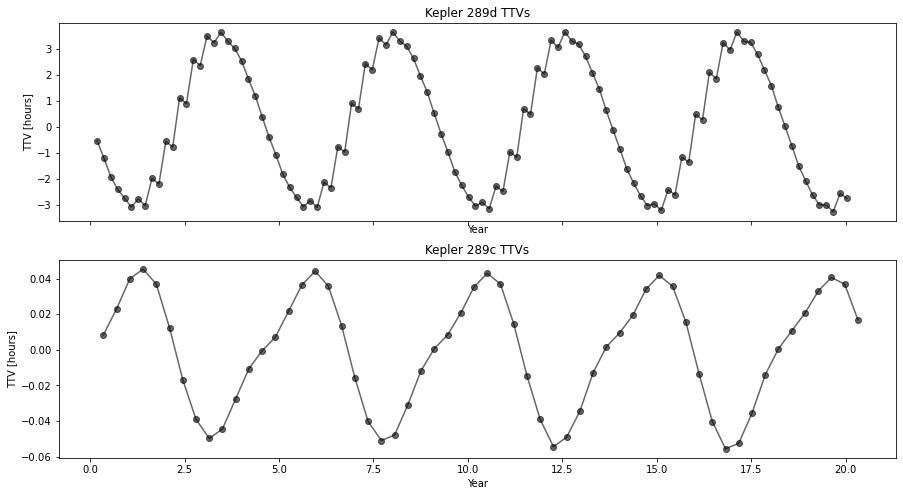

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.set_xlabel("Year")
ax1.set_ylabel("TTV [hours]")
ax1.plot((ts_289d*u.s).to(u.yr), (ttvs_289d)/(3600), 'ko-', alpha=.6)
ax1.set_title('Kepler 289d TTVs')
ax2.set_xlabel("Year")
ax2.set_ylabel("TTV [hours]")
ax2.plot((ts_289c*u.s).to(u.yr), (ttvs_289c)/(3600), 'ko-', alpha=.6)
ax2.set_title('Kepler 289c TTVs')
plt.show()

### Period and Amplitude of TTVs

In [28]:
print('Kepler 298c', '\n'+'-'*26)
get_ampl_per(ts_289c, ttvs_289c)
print()
print('Kepler 298d', '\n'+'-'*26)
get_ampl_per(ts_289d, ttvs_289d)

Kepler 298c 
--------------------------
Period of TTV    : 4.65 yr
Amplitude of TTV : 0.05 h

Kepler 298d 
--------------------------
Period of TTV    : 4.62 yr
Amplitude of TTV : 3.36 h


The periods are approximately the same as expected. The amplitude of the more massive planet (c) is much smaller than that of the less massive (d)

### Adjust the mass of planet c

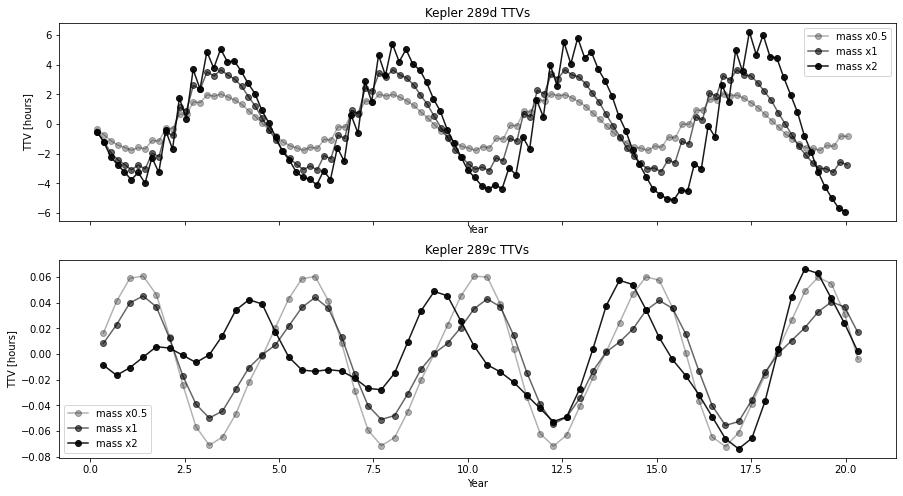

In [29]:
ts_289d, ttvs_289d = get_transit_times(planet_ind=1, years=20, period=P_289d)
ts_289c, ttvs_289c = get_transit_times(planet_ind=2, years=20, period=P_289c)

ts_289d_half, ttvs_289d_half = get_transit_times(planet_ind=1, years=20, period=P_289d, mass_factor=0.5)
ts_289c_half, ttvs_289c_half = get_transit_times(planet_ind=2, years=20, period=P_289c, mass_factor=0.5)

ts_289d_double, ttvs_289d_double = get_transit_times(planet_ind=1, years=20, period=P_289d, mass_factor=2)
ts_289c_double, ttvs_289c_double = get_transit_times(planet_ind=2, years=20, period=P_289c, mass_factor=2)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.set_xlabel("Year")
ax1.set_ylabel("TTV [hours]")
ax1.plot((ts_289d_half*u.s).to(u.yr), (ttvs_289d_half)/(3600), 'ko-', alpha=.3, label='mass x0.5')
ax1.plot((ts_289d*u.s).to(u.yr), (ttvs_289d)/(3600), 'ko-', alpha=.6, label='mass x1')
ax1.plot((ts_289d_double*u.s).to(u.yr), (ttvs_289d_double)/(3600), 'ko-', alpha=.9, label='mass x2')
ax1.set_title('Kepler 289d TTVs')
ax1.legend()
ax2.set_xlabel("Year")
ax2.set_ylabel("TTV [hours]")
ax2.plot((ts_289c_half*u.s).to(u.yr), (ttvs_289c_half)/(3600), 'ko-', alpha=.3, label='mass x0.5')
ax2.plot((ts_289c*u.s).to(u.yr), (ttvs_289c)/(3600), 'ko-', alpha=.6, label='mass x1')
ax2.plot((ts_289c_double*u.s).to(u.yr), (ttvs_289c_double)/(3600), 'ko-', alpha=.9, label='mass x2')
ax2.set_title('Kepler 289c TTVs')
ax2.legend()
plt.show()

### Period and amplitude after halving the mass of planet c

In [30]:
print('Kepler 298c', '\n'+'-'*26)
get_ampl_per(ts_289c_half, ttvs_289c_half)
print()
print('Kepler 298d', '\n'+'-'*26)
get_ampl_per(ts_289d_half, ttvs_289d_half)

Kepler 298c 
--------------------------
Period of TTV    : 4.65 yr
Amplitude of TTV : 0.07 h

Kepler 298d 
--------------------------
Period of TTV    : 4.62 yr
Amplitude of TTV : 1.89 h


Looks like the period of the TTVs is about the same, while the amplitude of d is noticeably lower (c is slightly greater). This is probably because this configuration causes the planets to orbit in a way that is further from an interger resonance, and also the decreased mass of planet c means the effect on planet d is also decreased.

### Period and amplitude after doubling the mass of planet d

In [31]:
print('Kepler 298c', '\n'+'-'*26)
get_ampl_per(ts_289c_double, ttvs_289c_double)
print()
print('Kepler 298d', '\n'+'-'*26)
get_ampl_per(ts_289d_double, ttvs_289d_double)

Kepler 298c 
--------------------------
Period of TTV    : 5.12 yr
Amplitude of TTV : 0.03 h

Kepler 298d 
--------------------------
Period of TTV    : 4.83 yr
Amplitude of TTV : 4.51 h


The periods are now slightly longer, and the amplitude of the TTV is also a bit higher for planet d, which is probably due to the increase in mass of planet c. I think this configuration is probably closer to an integer resonance as well, which causes the difference in period and an increase in the gain in the TTV signal.

## Long term TTVs

There's a slight trend in the TTV data even after applying the linear fit. To investigate this, we plot the TTVs over 1500 years:

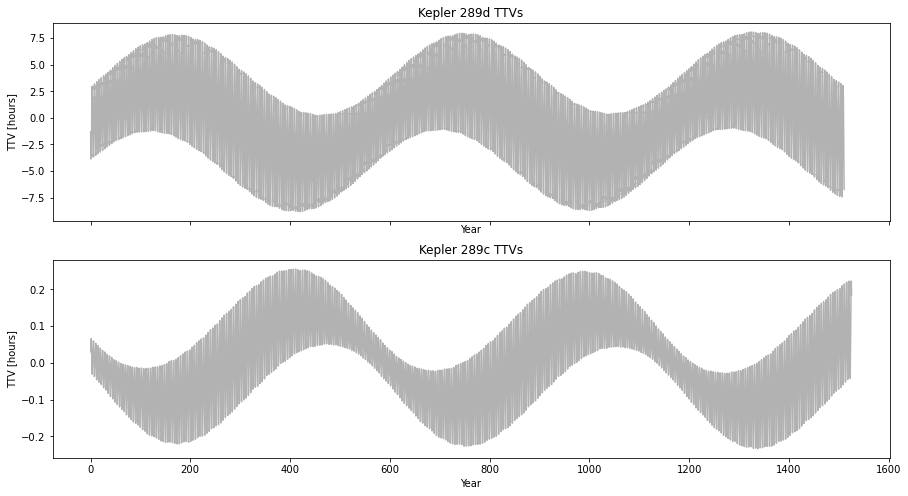

In [32]:
ts_289d, ttvs_289d = get_transit_times(planet_ind=1, years=1500, period=P_289d)
ts_289c, ttvs_289c = get_transit_times(planet_ind=2, years=1500, period=P_289c)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.set_xlabel("Year")
ax1.set_ylabel("TTV [hours]")
ax1.plot((ts_289d*u.s).to(u.yr), (ttvs_289d)/(3600), 'k-', alpha=.3)
ax1.set_title('Kepler 289d TTVs')
ax2.set_xlabel("Year")
ax2.set_ylabel("TTV [hours]")
ax2.plot((ts_289c*u.s).to(u.yr), (ttvs_289c)/(3600), 'k-', alpha=.3)
ax2.set_title('Kepler 289c TTVs')
plt.show()

It looks like the orbits of the planets may be varying on this timescale, which causes the resonances to change as well.

## Long term TTVs after doubling the mass of planet c

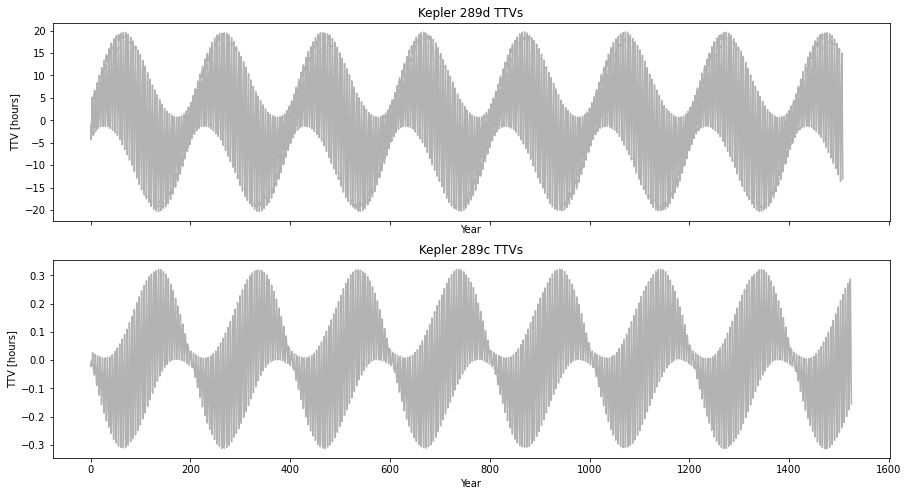

In [33]:
ts_289d, ttvs_289d = get_transit_times(planet_ind=1, years=1500, period=P_289d, mass_factor=2)
ts_289c, ttvs_289c = get_transit_times(planet_ind=2, years=1500, period=P_289c, mass_factor=2)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.set_xlabel("Year")
ax1.set_ylabel("TTV [hours]")
ax1.plot((ts_289d*u.s).to(u.yr), (ttvs_289d)/(3600), 'k-', alpha=.3)
ax1.set_title('Kepler 289d TTVs')
ax2.set_xlabel("Year")
ax2.set_ylabel("TTV [hours]")
ax2.plot((ts_289c*u.s).to(u.yr), (ttvs_289c)/(3600), 'k-', alpha=.3)
ax2.set_title('Kepler 289c TTVs')
plt.show()

This effect looks to be even more extreme after adding mass to the system, which changes the long term variations in the orbital cycles to something a bit higher in amplitude and frequency!